# Parallel TS Map computation

## Fast flux and TS Map calculation

### Possion distribution

A discrete random variable $X$ is said to have Poisson distribution, with parameter $\lambda>0$:
$$
f(k;\lambda)=\text{Pr}(X=k)=\frac{\lambda^ke^{-\lambda}}{k!},
$$
where:
- $k$ is the number of occurrences ($k=0,1,2,...$)
- $e$ is the Euler's number
- $\lambda$ is equal to the expectation and variance of $X$: $\lambda=\text{E}(X)=\text{Var}(X)$

### Maximum Poisson log-likelihood ratio test statistic (TS)

Here, we will examine two contradictory hypotheses:
- There are source photons emitted from a sky location (pixel) with likelihood $L(f)$, where $f$ is the source flux.
- There are only background photons emitted from a sky location (pixel) with likelihood $L(0)$, where $f=0$ since no source is present.

The log-likelihood ratio test statistic is defined as:
$$
L L R(f)=2 \log \frac{L(f)}{L(0)}=2 \sum_{i=1}^N \log \frac{P\left(b_i+e_i f, d_i\right)}{P\left(b_i, d_i\right)}
$$
$$
T S=\max L L R(f)=L L R(F)
$$


- $P(\lambda, n)$ is the Poisson probability for n photons with mean $\lambda$ (also called expectation)
    - $\lambda=b_i+e_i f$
        - $b_i$ is the background counts
        - $e_i$ is the expected excess per flux unit obtained from the detector response and source model (spectrum and location)
        - $f$ is the free parameter representing the flux from the source
    - $d_i$ is the measured count data, including both source and background photons
    - $F$ is the best estimated flux norm that maximizes $L L R(f)$

One good news is that $L L R(f)$ has analytic derivatives at all orders. What's more, the second-order derivative is always negative. Therefore, $L L R(f)$ has only one maximum, which can be solved by Newton-Raphson's method.
$$
L L R^{\prime}(f)=2 \sum\left(d_i \frac{e_i}{b_i+e_i f}-e_i\right)
$$
$$
L L R^{\prime \prime}(f)=-2 \sum\left(d_i \frac{e_i^2}{\left(b_i+e_i f\right)^2}\right)
$$

### Parallel Computation

The way we generate a TS map is to iterate through all pixels in an all-sky map. Although this generally works, it needs a tremendous amount of time when we want an all-sky map with a good resolution (3072 pixels or higher). A solution to speed it up is implementing parallel computation in our method. The idea is very simple: **The computation of pixels is independent of each other. Thus, we can perform the computations together, depending on the number of available CPU cores per user.**

Here let me describe the steps in the computation for a single pixel:

#### Step 1: Data Preparation

We need several data files to perform the TS map calculation
- <u>Measured (observational) data</u> in *hd5f* format (in this case, the measured data is simulated)
- <u>Background model</u> in *hd5f* format
- <u>Response</u> in *h5* format (we have both detector and galactic responses)
- <u>Orientation file</u> in *ori* format (needed when using detector response)
    
With those files, we can then:

- Read all the data files
- Generate a null all-sky map with a customized number of pixels
- Choose a pixel from the all-sky map
- Convolve the response with the pixel coordinate and spectrum to get the expected excess per flux unit $e_i$

#### Step 2: Data Projection
The data themselves have multiple axes. However, we only need Compton data space in a specific energy range. So, we will process the data to obtain the portion needed for the TS map.
- Slice the energy range we want
- Project to Compton data space (CDS).

    CDS is a 3D data space (Compton scattering angle, Psi, and Chi); here, I use a 2D slice (PsiChi) to represent CDS in the image below.

#### Steps 3: Newton-Raphson's Method
With the data we obtained from Step 2, we can construct the log-likelihood ratio function and find its global maximum. The returned maximum will be feedback to the pixel we picked as the TS value or the flux norm. At this point, the calculation of a pixel is completed.

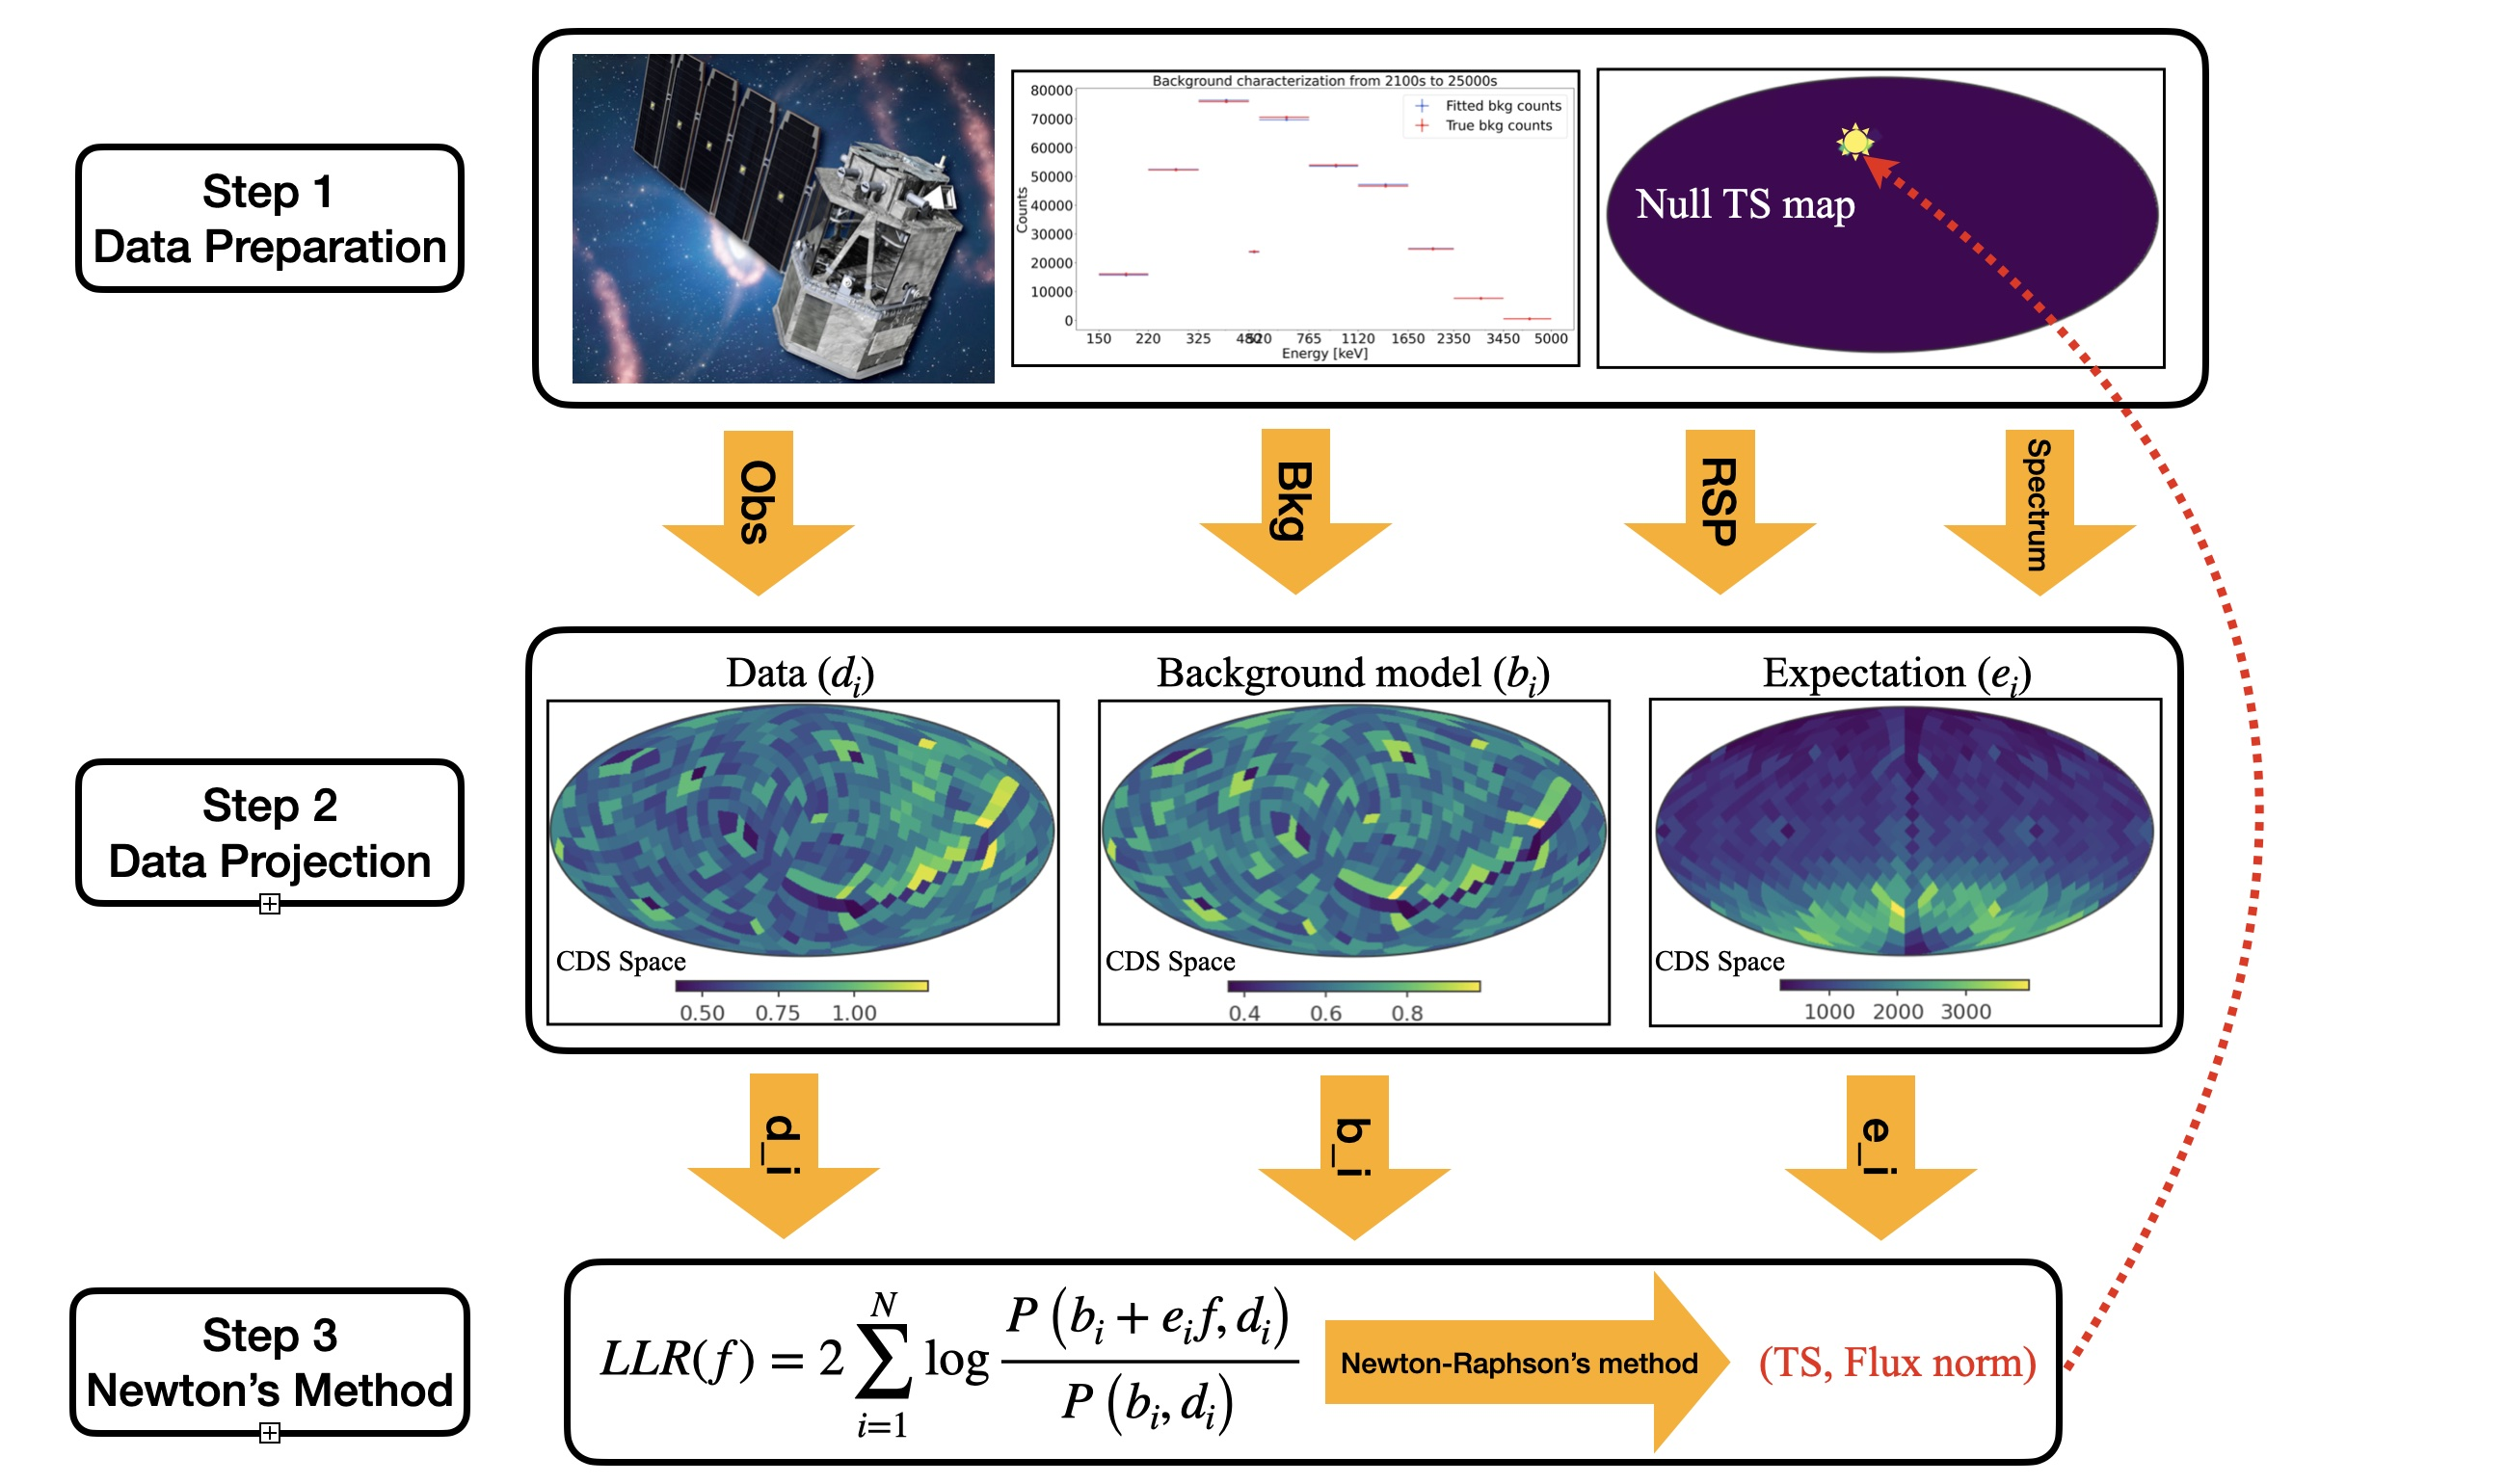

## Importing modules

In [1]:
%%capture
# import necessary modules
from threeML import Powerlaw
from cosipy import FastTSMap, SpacecraftFile
from cosipy.response import FullDetectorResponse
import astropy.units as u
from histpy import Histogram
from astropy.time import Time
import numpy as np
from astropy.coordinates import SkyCoord
from pathlib import Path
from mhealpy import HealpixMap
from matplotlib import pyplot as plt
import gc
from cosipy.util import fetch_wasabi_file
import shutil
import os

## Example 1: Fit the GRB using the Compton Data Space (CDS) in local coordinates (Spacecraft frame)

### Download data

The cells below contain the commands to download the data files needed for the GRB TS map fitting. 

The files will be downloaded to the same directory as this notebook.

In [2]:
%%capture
# GRB signal file ~76.90 KB
fetch_wasabi_file("COSI-SMEX/cosipy_tutorials/grb_spectral_fit_local_frame/grb_binned_data.hdf5")

In [2]:
%%capture
# background file ~255.97 MB
fetch_wasabi_file("COSI-SMEX/cosipy_tutorials/ts_maps/bkg_binned_data_local.hdf5")

In [4]:
%%capture
# orientation file ~684.38 MB
fetch_wasabi_file("COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori")

In [5]:
%%capture
# response file ~839.62 MB
fetch_wasabi_file("COSI-SMEX/DC2/Responses/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip")

# unzip the response file
shutil.unpack_archive("SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip")

# delete the zipped response to save space
os.remove("SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip")

### Define a powerlaw spectrum

In [6]:
index = -2.2
K = 10 / u.cm / u.cm / u.s / u.keV
piv = 100 * u.keV
spectrum = Powerlaw()
spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value 
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

### Read the data

#### Read the GRB signal, background component and assemble the data

We will read the GRB signal and extract the background component from the simulated 3-month background. After that, we can assemble the GRB signal and background to get the observed data.

In [7]:
# Read the GRB signal
signal = Histogram.open("grb_binned_data.hdf5")

# get the starting and ending time tag of the GRB
grb_tmin = signal.axes["Time"].edges.min()
grb_tmax = signal.axes["Time"].edges.max()

# project to three axes: measure energy(Em), scattering direction(PsiChi) and Compton scattering angle (Phi)
signal = signal.project(['Em', 'PsiChi', 'Phi'])

In [8]:
# load the background file
bkg_full = Histogram.open("bkg_binned_data_1s_local.hdf5")

# Extract 40s background from the 3-month one
bkg_tmin_idx = np.where(bkg_full.axes['Time'].edges.value == grb_tmin.value)[0][0]  # the time idx corresponding to the tima tag
bkg_tmax_idx = np.where(bkg_full.axes["Time"].edges.value == grb_tmax.value)[0][0]
bkg = bkg_full.slice[bkg_tmin_idx:bkg_tmax_idx,:]  # It slices the Time axis

# project to three axes: measure energy(Em), scattering direction(PsiChi) and Compton scattering angle (Phi)
bkg = bkg.project(['Em', 'PsiChi', 'Phi'])

In [9]:
# assemble the data
data = bkg + signal

#### Read the background model

Since we don't have a tool to estimate the background counts during a burst yet, here we average the full 3-month background down to the duraion of the burst (40s) to ensure good statistics.

In [10]:
# calculate the duration of the background
bkg_full_duration = (bkg_full.axes['Time'].edges.max() - bkg_full.axes['Time'].edges.min())

# average the background model down to 40s
bkg_model = bkg_full/(bkg_full_duration/40)

# project to three axes: measure energy(Em), scattering direction(PsiChi) and Compton scattering angle (Phi)
bkg_model = bkg_model.project(['Em', 'PsiChi', 'Phi'])

Text(0, 0.5, 'Counts')

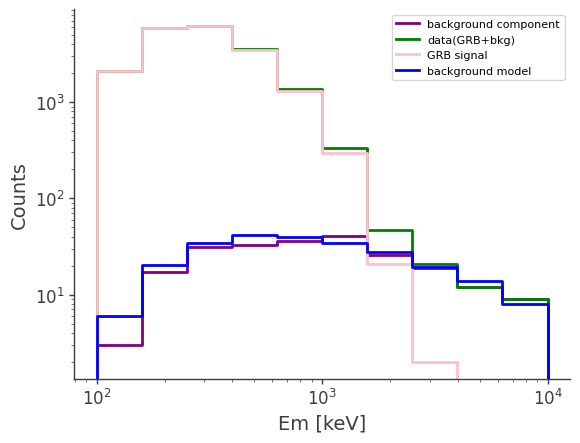

In [11]:
# plot the counts distribution
ax,plot = bkg.project("Em").draw(label = "background component", color = "purple")
data.project("Em").draw(ax, label = "data(GRB+bkg)", color = "green")
signal.project("Em").draw(ax, label = "GRB signal", color = "pink")
bkg_model.project("Em").draw(ax, label = "background model", color = "blue")

ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Counts")

#### Read the orientation

In [12]:
# read the full oritation but only get the interval for the GRB
ori_full = SpacecraftFile.parse_from_file("20280301_3_month.ori")
grb_ori = ori_full.source_interval(Time(grb_tmin, format = "unix"), Time(grb_tmax, format = "unix"))

# clear redundant data from RAM
del bkg_full
del ori_full
_ = gc.collect()

### Start TS map fit

In [13]:
# define the path to the response
response_path = Path("SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5")

# here let's create a FastTSMap object for fitting the ts map in the following cells
ts = FastTSMap(data = data, bkg_model = bkg_model, orientation = grb_ori, 
               response_path = response_path, cds_frame = "local", scheme = "RING")

In [14]:
# get a list of hypothesis coordinates to fit. The models will be put on these locations for get the expected counts from the source spectrum.
# note that this nside is also the nside of the final TS map
hypothesis_coords = FastTSMap.get_hypothesis_coords(nside = 16)

Below is the actual parallel fit:
- In default, the maximum number of cores it can use is `max_number-1`. You can also customize the number of cores you want to use by the `cpu_cores` parameter.
- energy channel is `[lower_channel, upper_channel]`. Lower channel is inclusive while the upper channel is exclusive
- This might take long in a personal computer

In [15]:
ts_results = ts.parallel_ts_fit(hypothesis_coords = hypothesis_coords, energy_channel = [2,3], spectrum = spectrum, ts_scheme = "RING", cpu_cores = 40)

You have total 64 CPU cores, using 40 CPU cores for parallel computation.
The time used for the parallel TS map computation is 1.803094466527303 minutes


### Plot the fitted TS map

In [16]:
# This the true location of the GRB
coord = SkyCoord(l=93, b = -53, unit = (u.deg, u.deg), frame = "galactic")

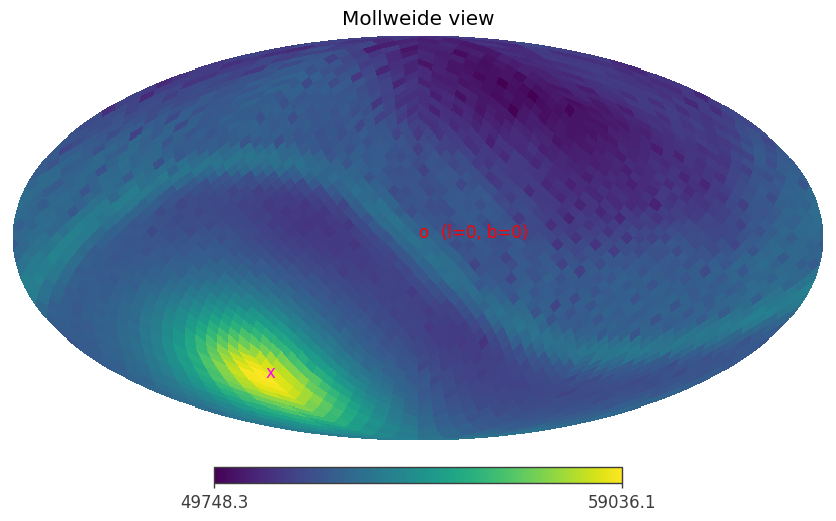

In [17]:
%matplotlib inline
ts.plot_ts(skycoord = coord)

The image above plots the raw TS values, which is also an image of the GRB. However, for the purpose of localization, we are more interested in the confidence level of the imaged GRB. Thus, you can plot the 90% containment level of the GRB location by setting `containment` parameter to the percetage you want to plot. However, because the strength of the GRB signal is very very strong, the ts map looks the same under different containment levels.

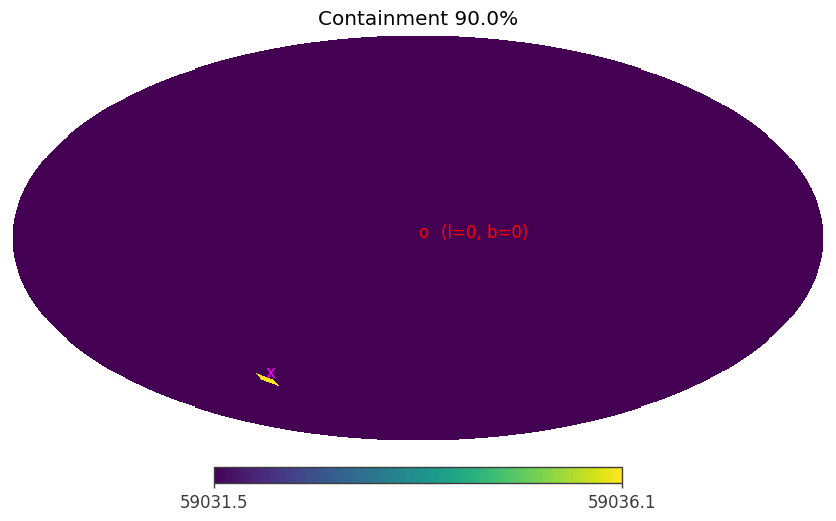

In [18]:
ts.plot_ts(skycoord = coord, containment = 0.9)

As you can see, the GRB region shrinks only to a single pixel. This is caused by the fact that the GRB signal is very very strong in this case. In the next section, we will manipulate the strength of the GRB signal to see how the front source signal affects the TS values and the 90% confidence region.

## Example 2: Fit a fainter GRB using the Compton Data Space (CDS) in local coordinates (Spacecraft frame)

This example uses exactly the same data file as example 1, so I don't repeat the downloading scripts here.

In [19]:
scaling_factor = 0.02

Here we will set up a scaling factor to manipulate the strength of the signal to see the affects on the final TS map. Since all the steps are exactly the same execpt the scaling factor, I will put the main codes in a single cell for simplicity.

**If you encounter any errors, please try to restart the notebook kernel or the whole session.**

You have total 64 CPU cores, using 40 CPU cores for parallel computation.
The time used for the parallel TS map computation is 1.7133230725924173 minutes


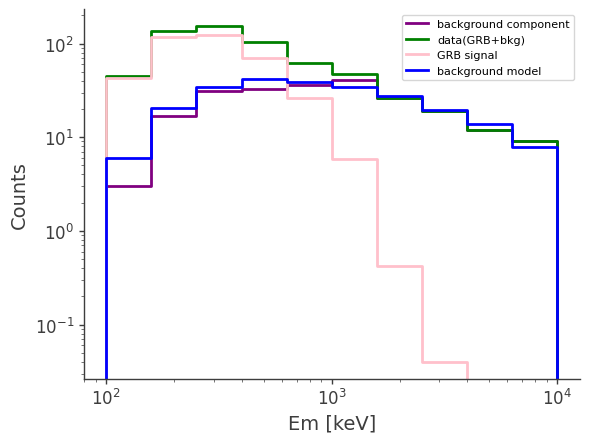

In [20]:
# define a powerlaw spectrum
index = -2.2
K = 10 / u.cm / u.cm / u.s / u.keV
piv = 100 * u.keV
spectrum = Powerlaw()
spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value 
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

# Read the GRB signal
signal = Histogram.open("grb_binned_data.hdf5")
# get the starting and ending time tag of the GRB
grb_tmin = signal.axes["Time"].edges.min()
grb_tmax = signal.axes["Time"].edges.max()
# project to three axes: measure energy(Em), scattering direction(PsiChi) and Compton scattering angle (Phi)
signal = signal.project(['Em', 'PsiChi', 'Phi'])*scaling_factor

# load the background file
bkg_full = Histogram.open("bkg_binned_data_1s_local.hdf5")
# Extract 40s background from the 3-month one
bkg_tmin_idx = np.where(bkg_full.axes['Time'].edges.value == grb_tmin.value)[0][0]  # the time idx corresponding to the tima tag
bkg_tmax_idx = np.where(bkg_full.axes["Time"].edges.value == grb_tmax.value)[0][0]
bkg = bkg_full.slice[bkg_tmin_idx:bkg_tmax_idx,:]  # It slices the Time axis
# project to three axes: measure energy(Em), scattering direction(PsiChi) and Compton scattering angle (Phi)
bkg = bkg.project(['Em', 'PsiChi', 'Phi'])

# assemble the data
data = bkg + signal

# calculate the duration of the background
bkg_full_duration = (bkg_full.axes['Time'].edges.max() - bkg_full.axes['Time'].edges.min())
# average the background model down to 40s
bkg_model = bkg_full/(bkg_full_duration/40)
# project to three axes: measure energy(Em), scattering direction(PsiChi) and Compton scattering angle (Phi)
bkg_model = bkg_model.project(['Em', 'PsiChi', 'Phi'])

# plot the counts distribution
ax,plot = bkg.project("Em").draw(label = "background component", color = "purple")
data.project("Em").draw(ax, label = "data(GRB+bkg)", color = "green")
signal.project("Em").draw(ax, label = "GRB signal", color = "pink")
bkg_model.project("Em").draw(ax, label = "background model", color = "blue")
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Counts")

# read the full oritation but only get the interval for the GRB
ori_full = SpacecraftFile.parse_from_file("20280301_3_month.ori")
grb_ori = ori_full.source_interval(Time(grb_tmin, format = "unix"), Time(grb_tmax, format = "unix"))

# clear redundant data from RAM
del bkg_full
del ori_full
_ = gc.collect()

# define the path to the response
response_path = Path("SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5")

# here let's create a FastTSMap object for fitting the ts map in the following cells
ts = FastTSMap(data = data, bkg_model = bkg_model, orientation = grb_ori, 
               response_path = response_path, cds_frame = "local", scheme = "RING")

# get a list of hypothesis coordinates to fit. The models will be put on these locations for get the expected counts from the source spectrum.
# note that this nside is also the nside of the final TS map
hypothesis_coords = FastTSMap.get_hypothesis_coords(nside = 16)

ts_results = ts.parallel_ts_fit(hypothesis_coords = hypothesis_coords, energy_channel = [2,3], spectrum = spectrum, ts_scheme = "RING", cpu_cores = 40)

In [21]:
# This the true location of the GRB
coord = SkyCoord(l=93, b = -53, unit = (u.deg, u.deg), frame = "galactic")

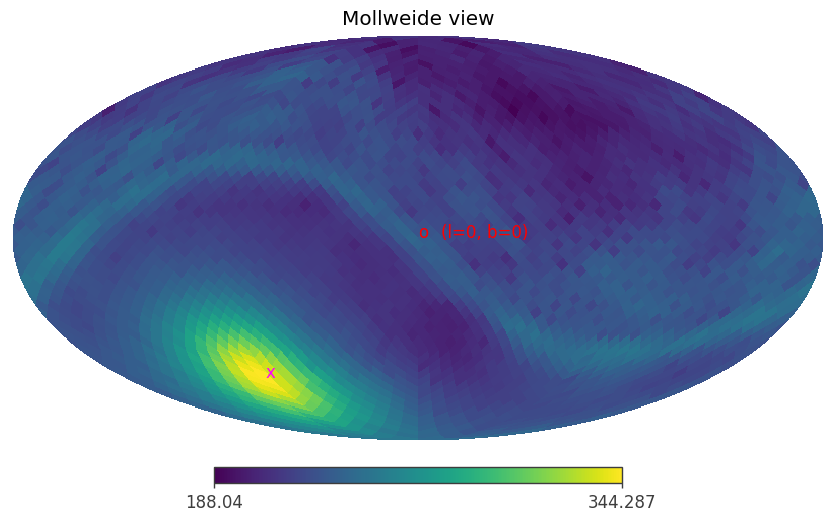

In [22]:
%matplotlib inline
ts.plot_ts(skycoord = coord)

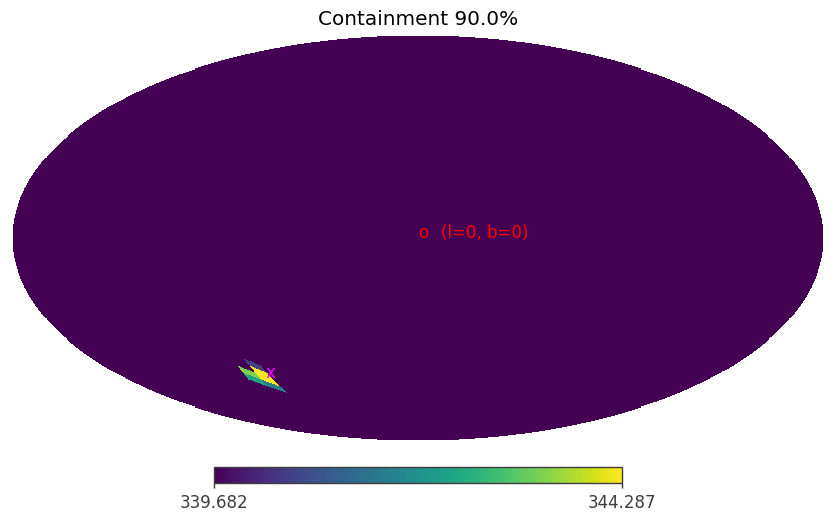

In [23]:
ts.plot_ts(skycoord = coord, containment = 0.9)

## Example 3: Fit Crab using the Compton Data Space (CDS) in galactic coordinates

The Crab case is similar to the GRB one. The difference is that the Crab data (signal and background) are binned in the galactic coordiates instead of the spacecraft coordinates. Therefore, we will need to use the galatic response for Crab. In addition, the orientation file is not needed since Crab is a fixed source in galactic coordinates.

### Bin data (optional)

If you want to binned the data by yourself, you can run this **Bin data** section. Otherwise, you can skip to the next section and use the binned data downloaded from Wasabi, which is faster.

#### Download unbinned data 

In [ ]:
%%capture
# 3-month unbinned Crab data ~619.22 MB
fetch_wasabi_file("COSI-SMEX/DC2/Data/Sources/Crab_DC2_3months_unbinned_data.fits.gz")

In [42]:
%%capture
# 3-month albede background data ~2.69 GB
fetch_wasabi_file("COSI-SMEX/DC2/Data/Backgrounds/albedo_photons_3months_unbinned_data.fits.gz")

#### Getting the binned Crab data

In [3]:
# Here is the code I used to bin the Crab data if you want to generate it by yourself.
from cosipy import BinnedData
# "Crab_bkg_galactic_inputs.yaml" can be used for both Crab and background binning since the only useful information in the yaml file is the binning of CDS
analysis = BinnedData("Crab_bkg_galactic_inputs.yaml")
analysis.get_binned_data(unbinned_data = "Crab_DC2_3months_unbinned_data.fits.gz", 
                         make_binning_plots=False, 
                         output_name = "Crab_galactic_CDS_binned", 
                         psichi_binning = "galactic")

# After you generate the binned data files, it should be saved to the same directory of this notebook

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


#### Getting the binned background data

In [3]:
# Here is the code I used to bin the background data if you want to generate it by yourself.
from cosipy import BinnedData
# "Crab_bkg_galactic_inputs.yaml" can be used for both Crab and background binning since the only useful information in the yaml file is the binning of CDS
analysis = BinnedData("Crab_bkg_galactic_inputs.yaml")
analysis.get_binned_data(unbinned_data = "albedo_photons_3months_unbinned_data.fits.gz", 
                         make_binning_plots = False,
                         output_name = "Albedo_galactic_CDS_binned",
                         psichi_binning = "galactic")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


### Read data and background

Here you can download the binned data to avioding the binning steps above.

#### Download the binned data

In [24]:
%%capture
# 3-month binned Crab data ~158 MB
fetch_wasabi_file("COSI-SMEX/cosipy_tutorials/ts_maps/Crab_galactic_CDS_binned.hdf5")

In [25]:
%%capture
# 3-month binned Albedo background data ~457.50 MB
fetch_wasabi_file("COSI-SMEX/cosipy_tutorials/ts_maps/Albedo_galactic_CDS_binned.hdf5")

In [2]:
# Read background model
bkg_model = Histogram.open("Albedo_galactic_CDS_binned.hdf5")  # please make sure you adjust the path to the files by yourself.
bkg_model = bkg_model.project(['Em', 'PsiChi', 'Phi'])

# Read the signal and bkg to assemble data = bkg + signal
signal = Histogram.open("Crab_galactic_CDS_binned.hdf5")
signal = signal.project(['Em', 'PsiChi', 'Phi'])

# Here the background is the same as the background model since they are simulations, thus we know the background very well.
bkg = Histogram.open("Albedo_galactic_CDS_binned.hdf5")
bkg = bkg.project(['Em', 'PsiChi', 'Phi'])

# Assemble the signal and background
data = bkg + signal

Text(0, 0.5, 'Counts')

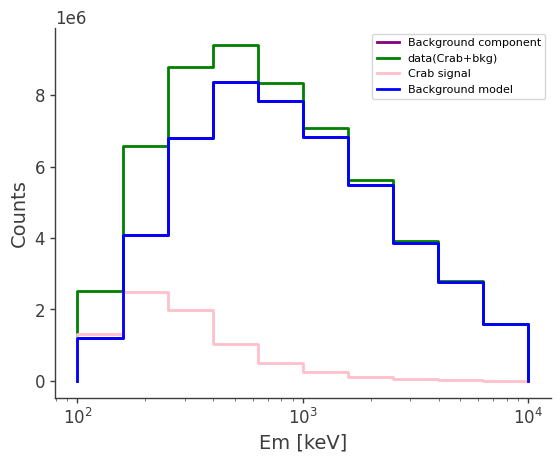

In [3]:
# plot the counts distribution
ax,plot = bkg.project("Em").draw(label = "Background component", color = "purple")
#data.project("Em").draw(ax, label = "data", color = "green")
data.project("Em").draw(ax, label = "data(Crab+bkg)", color = "green")
signal.project("Em").draw(ax, label = "Crab signal", color = "pink")
bkg_model.project("Em").draw(ax, label = "Background model", color = "blue")

ax.legend()
ax.set_xscale("log")
ax.set_ylabel("Counts")

In [4]:
# clear redundant data from RAM
del signal
del bkg
_ = gc.collect()

### Start TS map fit

In [5]:
# define a powerlaw spectrum
index = -3
K = 10**-3 / u.cm / u.cm / u.s / u.keV
piv = 100 * u.keV

spectrum = Powerlaw()
spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value 
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

In [6]:
%%capture
# download the galactic point source response ~6.69 GB

fetch_wasabi_file("COSI-SMEX/DC2/Responses/PointSourceReponse/psr_gal_continuum_DC2.h5.zip")

# unzip the response
shutil.unpack_archive("psr_gal_continuum_DC2.h5.zip")

# delete the zipped response to save space
os.remove("psr_gal_continuum_DC2.h5.zip")

In [7]:
# the galactic response file is available on wasabi
response_path = Path("psr_gal_DC2.h5")

# here let's create a FastTSMap object
ts = FastTSMap(data = data, bkg_model = bkg_model, response_path = response_path, cds_frame = "galactic", scheme = "RING")

In [8]:
# get a list of hypothesis coordinates to fit. The models will be put on these locations for get the expected counts from the source
# note that this nside is also the nside of the final TS map
hypothesis_coords = FastTSMap.get_hypothesis_coords(nside = 16)

In [10]:
# Perform the parallel fit
ts_results = ts.parallel_ts_fit(hypothesis_coords = hypothesis_coords, energy_channel = [1,2], spectrum = spectrum, ts_scheme = "RING", 
                                cpu_cores = 40)

You have total 56 CPU cores, using 40 CPU cores for parallel computation.
The time used for the parallel TS map computation is 1.3684121131896974 minutes


### Plot results

In [11]:
# This the true location of Crab
coord = SkyCoord(l=184.5551, b = -05.7877, unit = (u.deg, u.deg), frame = "galactic")

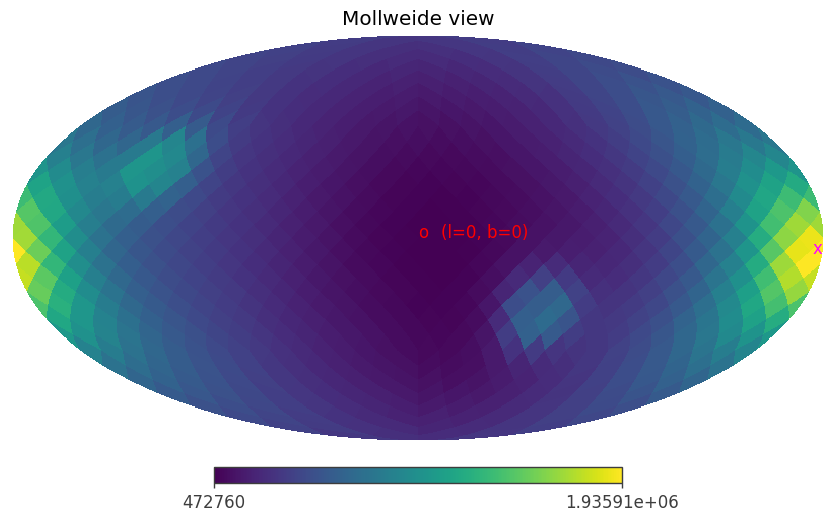

In [12]:
# plot the raw ts values
ts.plot_ts(skycoord = coord)

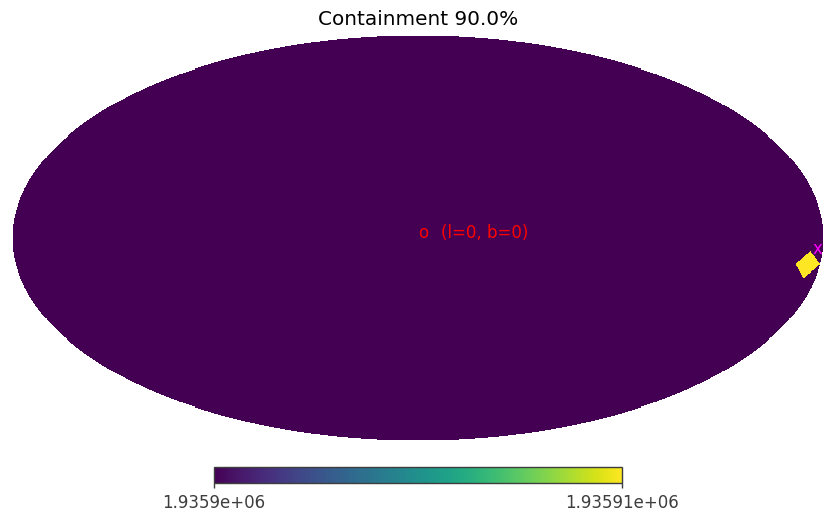

In [13]:
# plot the 90% confidence region
ts.plot_ts(skycoord = coord, containment = 0.9)

## Improvements in progress

The current method can generate the TS map for a GRB and Crab. However, the computation time needed on a personal laptop is still long and requires a massive amount of RAM (~30-40 GB). The future improvements will include:
- Optimization of the speed
    - Faster algorithm for Newton-Raphson's method
    - GPU computation
- Optimization of the RAM usage
    - Share memories among parallel processes